<center>
 <h1>ASSIGMENT-05</h1>
</center>

<center>
 <h3>DATA 266 GENERATIVE MODLE</h3>
</center>


<h5>Name: Gnana Prasuna Nimeesha Vakacharla </h5> 
<h5>SJSU ID: 017548115  </h5>


2. Train and Evaluate Autoencoders on FashionMNIST Dataset (PyTorch)

 Implementing:
- Fully Connected Autoencoder (FC-AE)
- Convolutional Autoencoder (CNN-AE)
- Sparse Autoencoder (Sparse-AE)
- Recurrent Autoencoder (RNN-AE)
- Variational Autoencoder (VAE)l (VAE)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load FashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
# Fully Connected Autoencoder
class FCAutoencoder(nn.Module):
    def __init__(self):
        super(FCAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)  # Reshape back to image
        return x

In [7]:
# Convolutional Autoencoder
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)  # Reshape back to image
        return x

In [9]:
# Recurrent Autoencoder
class RNNAutoencoder(nn.Module):
    def __init__(self):
        super(RNNAutoencoder, self).__init__()
        self.encoder = nn.LSTM(28, 128, batch_first=True)
        self.decoder = nn.LSTM(128, 28, batch_first=True)

    def forward(self, x):
        x = x.view(x.size(0), 28, 28)  # Reshape input for RNN (batch, seq, features)
        x, _ = self.encoder(x)
        x, _ = self.decoder(x)
        x = x.view(x.size(0), 1, 28, 28)  # Reshape back to image
        return x

In [10]:
# Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=32):  # Added latent_dim as a parameter
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc2_mean = nn.Linear(400, latent_dim)
        self.fc2_logvar = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28 * 28)
        self.latent_dim = latent_dim # Store the latent dimension

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2_mean(h), self.fc2_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x = self.decode(z)
        x = x.view(x.size(0), 1, 28, 28)  # Reshape back to image
        return x, mu, logvar

In [11]:
# Training Function


# Initialize Autoencoders
fc_autoencoder = FCAutoencoder()
cnn_autoencoder = CNNAutoencoder()
sparse_autoencoder = SparseAutoencoder()
rnn_autoencoder = RNNAutoencoder()
vae_autoencoder = VAE()

# Global variables to store final losses
final_train_losses = {}
final_test_losses = {}

# Training Function
def train_autoencoder(model, train_loader, test_loader, model_name, epochs=50, beta=0.5):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            
            if isinstance(model, VAE):
                output, mu, logvar = model(data)
                #Adjusted loss calculation with beta
                loss = criterion(output, data) + beta * 0.5 * torch.mean(-1 - logvar + mu.pow(2) + logvar.exp())
            else:
                output = model(data)
                loss = criterion(output, data)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Evaluate on test set
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                data = data.to(device)
                if isinstance(model, VAE):
                    output, mu, logvar = model(data)
                    #Adjusted loss calculation with beta
                    loss = criterion(output, data) + beta * 0.5 * torch.mean(-1 - logvar + mu.pow(2) + logvar.exp())
                else:
                    output = model(data)
                    loss = criterion(output, data)
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        
        # Print training status for the current model
        print(f"[{model_name}] Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Store final losses
    final_train_losses[model_name] = train_loss
    final_test_losses[model_name] = test_loss

# Train Models and Print Status
print("Training Fully Connected Autoencoder...")
train_autoencoder(fc_autoencoder, train_loader, test_loader, 'FC-AE')

print("Training Convolutional Autoencoder...")
train_autoencoder(cnn_autoencoder, train_loader, test_loader, 'CNN-AE')

print("Training Sparse Autoencoder...")
train_autoencoder(sparse_autoencoder, train_loader, test_loader, 'Sparse-AE')

print("Training Recurrent Autoencoder...")
train_autoencoder(rnn_autoencoder, train_loader, test_loader, 'RNN-AE')

print("Training Variational Autoencoder...")
train_autoencoder(vae_autoencoder, train_loader, test_loader, 'VAE')

# Print Final Losses
print("\nFinal Losses:")
for name in final_train_losses:
    print(f"{name} - Train Loss: {final_train_losses[name]:.4f}, Test Loss: {final_test_losses[name]:.4f}")

Training Fully Connected Autoencoder...
[FC-AE] Epoch [1/50], Train Loss: 0.0298, Test Loss: 0.0188
[FC-AE] Epoch [2/50], Train Loss: 0.0170, Test Loss: 0.0157
[FC-AE] Epoch [3/50], Train Loss: 0.0147, Test Loss: 0.0140
[FC-AE] Epoch [4/50], Train Loss: 0.0132, Test Loss: 0.0127
[FC-AE] Epoch [5/50], Train Loss: 0.0122, Test Loss: 0.0122
[FC-AE] Epoch [6/50], Train Loss: 0.0115, Test Loss: 0.0114
[FC-AE] Epoch [7/50], Train Loss: 0.0111, Test Loss: 0.0110
[FC-AE] Epoch [8/50], Train Loss: 0.0107, Test Loss: 0.0106
[FC-AE] Epoch [9/50], Train Loss: 0.0103, Test Loss: 0.0103
[FC-AE] Epoch [10/50], Train Loss: 0.0100, Test Loss: 0.0101
[FC-AE] Epoch [11/50], Train Loss: 0.0098, Test Loss: 0.0099
[FC-AE] Epoch [12/50], Train Loss: 0.0096, Test Loss: 0.0097
[FC-AE] Epoch [13/50], Train Loss: 0.0094, Test Loss: 0.0095
[FC-AE] Epoch [14/50], Train Loss: 0.0093, Test Loss: 0.0094
[FC-AE] Epoch [15/50], Train Loss: 0.0091, Test Loss: 0.0093
[FC-AE] Epoch [16/50], Train Loss: 0.0090, Test Loss: 

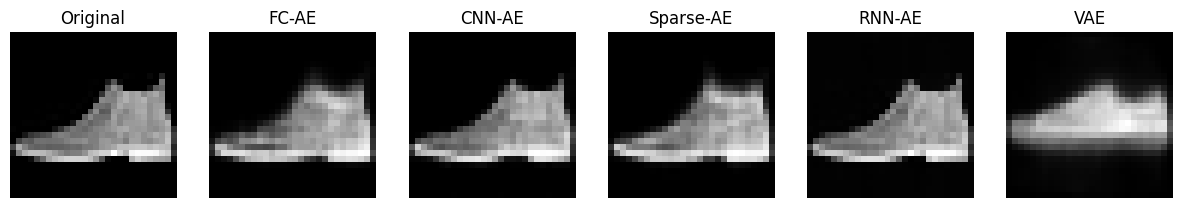

In [12]:
# Evaluate and Visualize Results
def evaluate_and_visualize(models, test_loader):
    test_data = next(iter(test_loader))[0][:1].to(device)
    fig, axs = plt.subplots(1, 6, figsize=(15, 3))
    axs[0].imshow(test_data.cpu().squeeze(), cmap='gray')
    axs[0].set_title('Original')
    axs[0].axis('off')
    
    for i, (name, model) in enumerate(models.items(), start=1):
        model.to(device)
        model.eval()
        with torch.no_grad():
            if name == 'VAE':
                decoded, _, _ = model(test_data)  # Get output, mu, logvar
            else:
                decoded = model(test_data) # Get output
        axs[i].imshow(decoded.cpu().squeeze(), cmap='gray')
        axs[i].set_title(name)
        axs[i].axis('off')
    
    plt.show()

# Dictionary of models
models = {
    'FC-AE': fc_autoencoder,
    'CNN-AE': cnn_autoencoder,
    'Sparse-AE': sparse_autoencoder,
    'RNN-AE': rnn_autoencoder,
    'VAE': vae_autoencoder
}

evaluate_and_visualize(models, test_loader)